# Eye-tracker pupil detection model   
<hr></hr>
<b>Author:</b> Owen Burt  

<b>Date created:</b> 2/21/2025

<b>Last modified</b> 3/6/2025  

<hr></hr>

<b>Description:</b>  

In this notebook I prepare data and construct a model that predicts the location of a pupil. 

<b>References:</b>  
- Referenced <b>mathworks.com</b> to learn about r-cnn, fast r-cnn, and faster r-cnn.
- Referenced and used code from the AI text book 'Applied Machine Learning and AI for Engineers' used in the AI/ML course by <b>Jeff Prosise</b>.
- Referenced and used code from <b>Tensorflow</b> to help understand tensorflows framework, use their pre-trained models, and output images with matlibplot.
- Referneced paper on Faster Convolutional Neural Networks from Cornell Univeristy called 'Faster R-CNN: Towards Real-Time Object Detection with Region Proposal Networks' by <b>Shaoqing Ren, et al</b>. I used this article to help me understand the Faster R-CNN.

<b>Sources:</b>  
- mathworks.com: https://www.mathworks.com/help/vision/ug/getting-started-with-r-cnn-fast-r-cnn-and-faster-r-cnn.html
- Tensorflow: https://www.tensorflow.org/tutorials/images/cnn
- Cornell Univeristy: https://arxiv.org/abs/1506.01497  


<hr></hr>
  


In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2
import os as os

# Data preprocessing

I'm starting with a folder containing all the images and their corresponding annotations as well as a csv that contains the file name of the image and the boundries of the pupil. In order to train a model on this data I will need each image (features) to be a 3D array conatinaing pixel data and the boundries (target) to be an array that corresponds to the correct image in the 3D array of images.


In [2]:
cwd = os.getcwd()
df = pd.read_csv(cwd + "/eye_data.csv")

In [3]:
df.head()

,file_name,obj_class,x1,y1,x2,y2
0,WIN_20250205_16_00_55_Pro.jpg,pupil,257,163,276,195
1,WIN_20250205_16_00_56_Pro.jpg,pupil,279,128,308,156
2,WIN_20250205_16_00_57_Pro.jpg,pupil,313,138,346,170
3,WIN_20250205_16_00_58_Pro.jpg,pupil,278,141,305,172
4,WIN_20250205_16_00_59_Pro.jpg,pupil,263,150,286,181


### Splitting data into training, testing, and validation groups.


My training data will be 75% of original dataset, testing will be 10%, and validation will be 15%


In [4]:

from sklearn.model_selection import train_test_split

X = df['file_name']
y = df[['x1', 'y1', 'x2', 'y2']]

train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio)) 


In [5]:
X_val.head()

296    WIN_20250208_18_45_25_Pro.jpg
367    WIN_20250220_20_01_30_Pro.jpg
280    WIN_20250208_18_45_02_Pro.jpg
247    WIN_20250208_18_44_15_Pro.jpg
167    WIN_20250208_18_41_21_Pro.jpg
Name: file_name, dtype: object

In [6]:
y_val.head()

,x1,y1,x2,y2
296,329,158,352,180
367,0,0,0,0
280,317,155,339,178
247,333,145,354,165
167,250,154,270,186


### Converting images and boundry data to arrays and normalizing 

Currently, <b>X_data</b> is a <u>series</u> of file names and <b>y_data</b> is a <u>dataframe</u> containing boundry data. I want the training data to be an <u>array</u> of pixel data and the target data to be an <u>array</u> containing just the boundries with no labels/index. I will create a function that handles both of these tasks. Along with converting data to array format these funcitons will also handle normalizing the data. For the images I do this by dividing the pixel data by 255 since a pixel is comprised of three values ranging from 0 to 255. Dividing by 255 gives me pixel data that ranges from 0 to 1. I treat the boudries similarly and divide x values by the width of my image and y values by the height leaving me with boundry data that ranges form 0 to 1. 


#### Creating functions

In [7]:
# may not need to resize the image if I use the fast r-cnn with tensorflow
def resize_image(image):
    image = tf.image.resize(image, [512, 512])
    return image

def images_to_arr(X):
    '''
    images_to_arr gets image path, loads the image, then converts it to a 3D array. 
        It also normalizes the pixel values to be between 0 - 1 and converts the image to greyscale.
    
    :param X: the series of image file names to be converted.
    '''
    X_data = []
    for i in range(len(X)):
        img_path = cwd + '\\image_data\\' + df['file_name'][i]
        image = tf.keras.utils.load_img(img_path)
        image_as_arr = tf.keras.utils.img_to_array(image)
        image_as_arr = resize_image(image_as_arr)/255.0 # resizing
        image_final = tf.image.rgb_to_grayscale(image_as_arr)
        X_data.append(image_final)
    return np.array(X_data)


In [8]:
def bounds_to_arr(y):
    '''
    bounds_to_arr converts boundry data from a dataframe to a np array containing just the coordinates. 
        It also normalizes the boundry values to be between 0 and 1

    :param y: the dataframe of boundry data to be converted.
    '''
    img_width = 640.0
    img_hight = 360.0
    y_data = []
    for i in range(len(y)):
        x1 = round(y.iloc[i].iloc[0]/img_width, 3)
        y1 = round(y.iloc[i].iloc[1]/img_hight, 3)
        x2 = round(y.iloc[i].iloc[2]/img_width, 3)
        y2 = round(y.iloc[i].iloc[3]/img_hight, 3)
        y_data.append((x1,y1, x2, y2))
    return np.array(y_data)

#### Executing functions

In [9]:
X_train = images_to_arr(X_train)
y_train = bounds_to_arr(y_train)
X_test = images_to_arr(X_test)
y_test = bounds_to_arr(y_test)
X_val = images_to_arr(X_val)
y_val = bounds_to_arr(y_val)

#### Visualizing data after preprocessing is complete

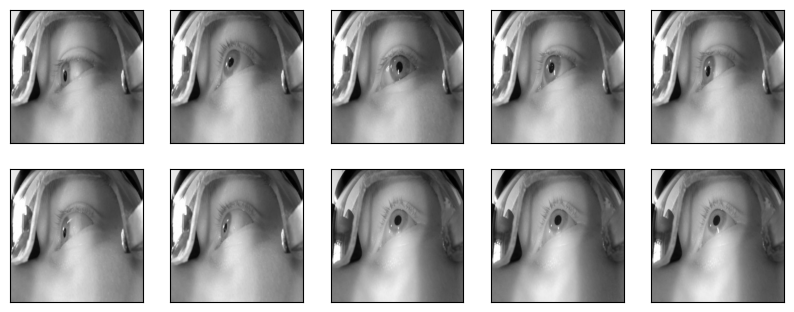

In [26]:
#code is from tensorflow website
#https://www.tensorflow.org/tutorials/images/cnn

import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap='grey')
plt.show()

In [18]:
X_train[1].shape

(512, 512, 1)

<hr></hr>

## Selecting and Building a Model  

I am beginning by pretty much copying a model from the 'Applied Machine Learning and AI for Engineers' text book to get a benchmark of where the data is at and what my model might need. The originial code can be found in the text book on page 254. I made one edit to the code and changed the loss funciton to mean squared error since my output layer is of size 4.  

### Running a Simple Convolutional Neural Network for Experimentation

In [12]:
#one edit I made was to change the loss funciton to mean squared error.
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import SGD
loss = Huber(delta=1.0)

model = Sequential()
#the type of model is important and I should read more about this. 
model.add(Conv2D(24, (3, 3), activation='relu', input_shape=(512, 512, 1)))
#Conv2D applies a convolution (2-dimentional for images since images are 2D) to the input image. 
#The parameter 64 refers to the number of filters applied in the covolution.
#a filter is a stack of kernels. In this case each filter has 3 kernels since there are three channels specified in the input_shape param (image are usually RGB hence 3 channels. one for red one for green one for blue)
#the second param (3, 3) specifies the shape of the kerel applied.
#I should really learn more about activation functions relu or rectified linear unifying is common but this should be selected based on your data
#imput shape refers to the size of the image being passed into the layer. In this case I resized all of my images to be 512 pixels wide and 512 pixels high. Each image is not RGB so maybe I should change the channel.
model.add(MaxPooling2D(2, 2)) 
#Pooling is done to decrease compute time and helps to control overfitting by reducing the feature map output by the previous layer. 
#Here were using maxpooling2d with shape 2x2 I am pretty sure this slides a 2x2 matrix across the featuremap reducing that 2x2 portion of the 
#image down to a 1x1 block containing the maximum value in the 2x2 matrix.
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (4, 4), activation='relu'))
model.add(MaxPooling2D(2, 2)) 
#Fully connected layers require 1D imputs. A flattening layer is added to convert 2D or 3D tensor (tensor is can be thought of as a n-dimentional matrix in this case 2x2 matrix) into a 1D vector
model.add(Flatten())
#The dense layers convert the flattened feature maps to probabilities. the first param is how many output units youwant
#In this case my final dense layer has 4 units since I am predicting 4 points for boundries. 
#activation matters and I should look more into this.
model.add(Dense(512, activation='relu'))
model.add(Dense(4, activation='linear'))
model.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9), loss=loss,
             metrics=['accuracy'])
model.summary(line_length=80)

Model: "sequential"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 conv2d (Conv2D)                    (None, 510, 510, 24)            240         
                                                                                
 max_pooling2d (MaxPooling2D)       (None, 255, 255, 24)            0           
                                                                                
 conv2d_1 (Conv2D)                  (None, 253, 253, 32)            6944        
                                                                                
 max_pooling2d_1 (MaxPooling2D)     (None, 126, 126, 32)            0           
                                                                                
 conv2d_2 (Conv2D)                  (None, 124, 124, 64)            18496       
                                                                                
 max_poo

In [14]:
hist = model.fit(X_train, y_train,
                validation_data=(X_test, y_test),
                batch_size=100, epochs=5)

Epoch 1/5
3/3 [==============================] - 50s 13s/step - loss: 0.0146 - accuracy: 0.4891 - val_loss: 0.0116 - val_accuracy: 0.4324
Epoch 2/5
3/3 [==============================] - 40s 12s/step - loss: 0.0146 - accuracy: 0.4710 - val_loss: 0.0114 - val_accuracy: 0.4054
Epoch 3/5
3/3 [==============================] - 34s 10s/step - loss: 0.0145 - accuracy: 0.4674 - val_loss: 0.0111 - val_accuracy: 0.4324
Epoch 4/5
3/3 [==============================] - 31s 10s/step - loss: 0.0146 - accuracy: 0.4710 - val_loss: 0.0110 - val_accuracy: 0.4324
Epoch 5/5
3/3 [==============================] - 30s 10s/step - loss: 0.0146 - accuracy: 0.4601 - val_loss: 0.0111 - val_accuracy: 0.4324


[]

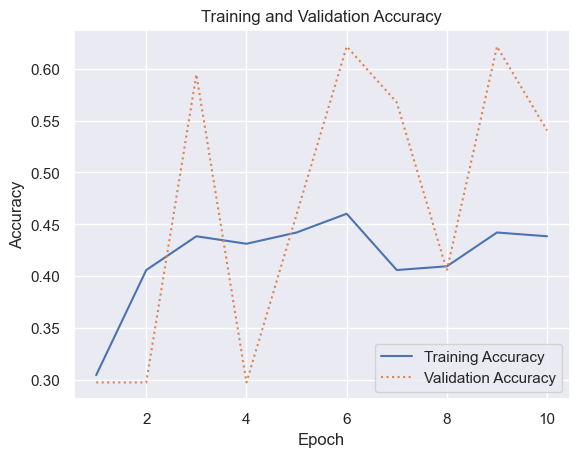

In [ ]:
import seaborn as sns
sns.set()
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

#### Copying VGG16 model

In [14]:
type(X_val[1])

numpy.ndarray

In [23]:
len(X_val[1][1][0])

1

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 512, 512, 64)      640       
                                                                 
 conv2d_19 (Conv2D)          (None, 512, 512, 64)      36928     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 256, 256, 64)     0         
 2D)                                                             
                                                                 
Total params: 37,568
Trainable params: 37,568
Non-trainable params: 0
_________________________________________________________________
2/2 [==============================] - 4s 458ms/step


<function matplotlib.pyplot.show(close=None, block=None)>

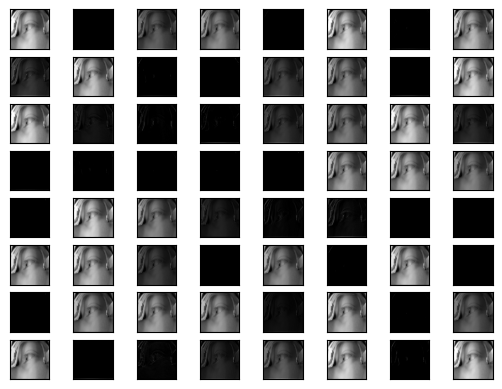

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential()

#Block 1
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(512, 512, 1)))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2))) 

model.build()
model.summary()

#show feature map after conv layer
result = model.predict(X_test)

for i in range(64):
    feature_img = result[0, :, :, i]
    ax = plt.subplot(8, 8, i+1)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(feature_img, cmap='grey')
plt.show


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 512, 512, 64)      640       
                                                                 
 conv2d_25 (Conv2D)          (None, 512, 512, 64)      36928     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 256, 256, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 256, 256, 128)     73856     
                                                                 
 conv2d_27 (Conv2D)          (None, 256, 256, 128)     147584    
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 128, 128, 128)    0         
 g2D)                                                

<function matplotlib.pyplot.show(close=None, block=None)>

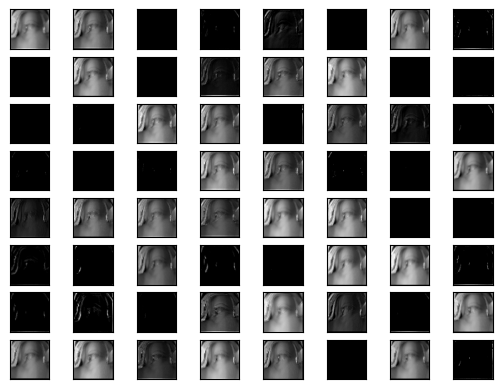

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential()

#Block 1
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(512, 512, 1)))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2))) 

#Block 2
model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#Block 3
model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))


model.build()
model.summary()

#show feature map after conv layer
result = model.predict(X_test)

for i in range(64):
    feature_img = result[0, :, :, i]
    ax = plt.subplot(8, 8, i+1)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(feature_img, cmap='grey')
plt.show


Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_42 (Conv2D)          (None, 512, 512, 64)      640       
                                                                 
 conv2d_43 (Conv2D)          (None, 512, 512, 64)      36928     
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 256, 256, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_44 (Conv2D)          (None, 256, 256, 128)     73856     
                                                                 
 conv2d_45 (Conv2D)          (None, 256, 256, 128)     147584    
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 128, 128, 128)    0         
 g2D)                                                

<function matplotlib.pyplot.show(close=None, block=None)>

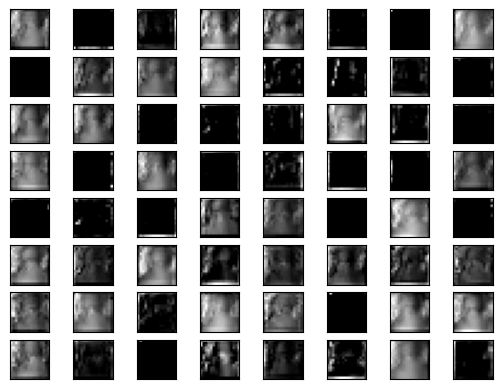

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential()

#Block 1
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(512, 512, 1)))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2))) 

#Block 2
model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#Block 3
model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#Block 4
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#Block 5
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))


model.build()
model.summary()

#show feature map after conv layer
result = model.predict(X_test)

for i in range(64):
    feature_img = result[0, :, :, i]
    ax = plt.subplot(8, 8, i+1)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(feature_img, cmap='grey')
plt.show

In [27]:
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(4, activation='linear'))

Running this test model provided a solid starting point and helped refine my focus. I found that training a CNN on large 360x640 images is inefficient. Initially, I considered cropping images to highlight the target object before resizing, but this is time-consuming. Instead, I can use a region-based CNN (R-CNN), which employs a region proposal layer to select relevant portions of the image for processing rather than analyzing the entire image at once. It would probably still be good to crop my images and if I think the model isn't accurate enough I might later on.

I plan to build a Faster R-CNN, the most efficient R-CNN variant with the lowest latency.  

I may also explore the YOLO (You Only Look Once) object detection model, which has the lowest latency among detection models. Like R-CNN, YOLO partitions the image before processing, making it a strong candidate for my application.

<hr></hr>

### Creating a Faster Region-based Convolutional Neural Network  

#### Faster R-CNN structure:  

- <b>Backbone network</b> - A pre-trained CNN used as a feature extractor. This network processes the entire input image to get a rich feature map that subsequently encodes the hierarchical visual information.  
- <b>Region Proposal Network (RPN)</b> - Takes in the feature map produced by the backbone network and predicts multiple region proposals based on it. Each region is given a score on how likely an object might be present. The RPN uses <b>anchors</b> which are predefined boxes of differing scale centered at each location in the feature map. For each anchor the RPN does two things. First it assigns the score of how likely an object is present. Second it refines the bounds to better fit the object.  
- <b>Region of Interest pooling layer</b> -   


#### Backbone network:  
Tensorflow offers a few pre-trained models that I can use as my backbone network.  
- <b>ResNet</b> -> `ResNet50`, `ResNet101`
- <b>MobileNet</b> -> `MobileNet`, `MobileNetV2`, `MobileNetV3`
- <b>VGG</b> -> `VGG16`, `VGG19`
- <b>EfficientNet</b> -> `EfficientNetB0` - `EfficientNetB7`
These are imported with `from tensorflow.keras.applications import < model name >`.  

There are also other frameworks that offer pre-trained models for Faster R-CNN backbone networks like PyTorch. Since I already have Tensorflow installed I will use a Tensorflow Keras model.

##### Loading Pre-Trained Backbone model (feature extractor)  

After comparing models on Keras MobileNet looks like a good fit. It has an average accuracy of 70% and compared to other models offered by Keras it has a lower latency. Info on MobileNet found here https://keras.io/api/applications/mobilenet/ 

In [17]:
from tensorflow.keras.applications import MobileNet

backbone = MobileNet(input_shape=(512, 512, 1), include_top=False, weights=None)
'''
MobileNet

:param input_shape: (image hight, image width, channel) MobileNet also allows for dynamic imput size ex: (None, None, 3)
:param include_top: set to false to exclude fully connected layers since this is used for feature extraction classification layers are not neccessary.
:param weights: dataset that specifies pre-trained weights. set to none since I am training this on my own data.
'''

'\nMobileNet\n\n:param input_shape: (image hight, image width, channel) MobileNet also allows for dynamic imput size ex: (None, None, 3)\n:param include_top: set to false to exclude fully connected layers since this is used for feature extraction classification layers are not neccessary.\n:param weights: dataset that specifies pre-trained weights. set to none since I am training this on my own data.\n'

##### Extracting Features From Backbone Network  

I referenced this article to find out what I am doing here: https://medium.com/@vaibhavsingh294/creating-a-feature-extraction-model-using-tensorflow-and-keras-e1248c65cef3. 

In [ ]:
features = tf.keras.Model(inputs=backbone.input,
                          outputs=backbone.get_layer('conv_dw_8_relu').output) #for outputs I am selecting a mid-level layer that is not too 
features.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512, 512, 1)]     0         
                                                                 
 conv1 (Conv2D)              (None, 256, 256, 32)      288       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 256, 256, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 256, 256, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 256, 256, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 256, 256, 32)     128       
 ation)                                                    

#### Region Proposal Network  

I am creating two functions, one to build the RPN and another to generate anchor boxes.

##### Building the RPN Model

In [ ]:
''' 
The RPN needs to 
1. Define anchor boxes
2. Create a small convolutional neural network on top of the backbone features
    to predict ogjectness scores and bounding box regressions for each anchor box
3. Apply non-maximum suppression to filter anchor box proposals


Binary cross-entropy loss is used for objectness scores
Smooth L1 loss is used for the boinding box regression branch

'''

' \nThe RPN needs to \n1. Define anchor boxes\n2. Create a small convolutional neural network on top of the backbone features\n    to predict ogjectness scores and bounding box regressions for each anchor box\n3. Apply non-maximum suppression to filter anchor box proposals\n\n\nBinary cross-entropy loss is used for objectness scores\nSmooth L1 loss is used for the boinding box regression branch\n\n'